In [1]:
import numpy as np
np.set_printoptions(precision=2)

from mrobotics.piecewise.polyline import polyline
from projection_testing import test_projection, viz_projection
import matplotlib.pyplot as plt

In [2]:
mywaypoints = polyline(np.array([
    [-3.0,4.0],
    [0.0,0.0],
    [+4.0, 3.0],
    [6.0, 2.0]
]))

test_arclengths = np.linspace(-2.0, 15.0, 100) # a very dense sample

## A basic test (zeroth-order information)

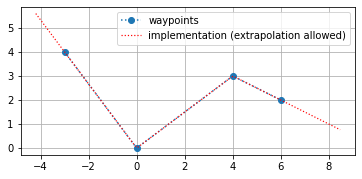

In [3]:
pts_test = mywaypoints.get_pos(test_arclengths,clip=False)
_, ax = plt.subplots()
mywaypoints.viz(ax=ax)
ax.plot(*pts_test.T, ':r',lw=1.2, label='implementation (extrapolation allowed)')
ax.legend()
plt.show()

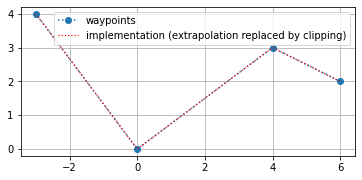

In [4]:
pts_test = mywaypoints.get_pos(test_arclengths,clip=True)
_, ax = plt.subplots()
mywaypoints.viz(ax=ax)
ax.plot(*pts_test.T, ':r',lw=1.2, label='implementation (extrapolation replaced by clipping)')
ax.legend()
plt.show()

In [5]:
print("Inspect the breakpoint")
print(mywaypoints.idx2arclen)

Inspect the breakpoint
[ 0.    5.   10.   12.24]


## First-order information

In [6]:
def test_utang_batch(test_arclengths,**kwargs):
    assert test_arclengths.ndim == 1
    N = len(test_arclengths)
    unit_tangents = mywaypoints.get_utang(test_arclengths,**kwargs)
    for i in range(N):
        print("unit tangent at", f"{test_arclengths[i]:3.2f}".rjust(7), unit_tangents[i]) 
    np.testing.assert_allclose(np.linalg.norm(unit_tangents, axis=1, ord=2), 1.0)    

In [7]:
test_utang_batch(test_arclengths[::10],clip=False)

unit tangent at   -2.00 [ 0.6 -0.8]
unit tangent at   -0.28 [ 0.6 -0.8]
unit tangent at    1.43 [ 0.6 -0.8]
unit tangent at    3.15 [ 0.6 -0.8]
unit tangent at    4.87 [ 0.6 -0.8]
unit tangent at    6.59 [0.8 0.6]
unit tangent at    8.30 [0.8 0.6]
unit tangent at   10.02 [ 0.89 -0.45]
unit tangent at   11.74 [ 0.89 -0.45]
unit tangent at   13.45 [ 0.89 -0.45]


In [8]:
# alternatively you can query one path parameter at a time.
for test_param in test_arclengths[::10]:
    print("unit tangent at", f"{test_param:3.2f}".rjust(7), mywaypoints.get_utang(test_param,clip=True))

unit tangent at   -2.00 [[ 0.6 -0.8]]
unit tangent at   -0.28 [[ 0.6 -0.8]]
unit tangent at    1.43 [[ 0.6 -0.8]]
unit tangent at    3.15 [[ 0.6 -0.8]]
unit tangent at    4.87 [[ 0.6 -0.8]]
unit tangent at    6.59 [[0.8 0.6]]
unit tangent at    8.30 [[0.8 0.6]]
unit tangent at   10.02 [[ 0.89 -0.45]]
unit tangent at   11.74 [[ 0.89 -0.45]]
unit tangent at   13.45 [[ 0.89 -0.45]]


## Add waypoints to extend the polyline path

In [9]:
mywaypoints.add(np.array([5,1]))

In [10]:
print("Inspect the breakpoint again (after adding the new point)")
mywaypoints.idx2arclen

Inspect the breakpoint again (after adding the new point)


array([ 0.  ,  5.  , 10.  , 12.24, 13.65])

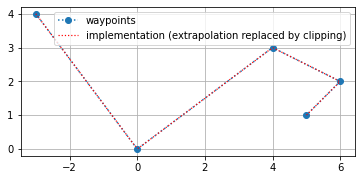

In [11]:
pts_test = mywaypoints.get_pos(test_arclengths,clip=True)
_, ax = plt.subplots()
mywaypoints.viz(ax=ax)
ax.plot(*pts_test.T, ':r',lw=1.2, label='implementation (extrapolation replaced by clipping)')
ax.legend()
plt.show()

## Validate the query point projection
Find
$$
s^*(\vec q) 
\triangleq 
\text{ argmin}_{s \in \mathbb{R}} 
\| \vec q - \vec p(s) \|_2
= 
 \text{ argmin}_{s \in \mathbb{R}} 
\| \vec q - \vec p(s) \|^2_2
$$

where 

* $\vec q$ is the query point
* $\vec p(s)$ is the point of our parametric curve evaluated at $s$ (with extrapolation)
* $\hat n(s)$ is the unit normal of the parametric curve evaluated at $s$ (with extrapolation)


Instead of searching for the true globally.
We have a stateful computation:

* avoid abrupt changes in the arclength (to some extent, cf. the Padan et al. (2017) paper for an illustration).

* We might also prefer the local minimizer that is closer to the "previous path progress estimate" instead of the global minimum.

Be prepared! The following query point has 3 local minima!
------------------------------
working on iteration 0: new iterate 9.400
working on iteration 1: new iterate 9.400
init guess: 6.00, final iterate: 9.40, (signed) projected distance: -0.80, took 0.17 msec
------------------------------
working on iteration 0: new iterate 10.447
working on iteration 1: new iterate 10.447
init guess: 10.00, final iterate: 10.45, (signed) projected distance: -0.89, took 0.15 msec
------------------------------
working on iteration 0: new iterate 13.650
working on iteration 1: new iterate 13.650
init guess: 13.00, final iterate: 13.65, (signed) projected distance: -1.41, took 0.072 msec
------------------------------


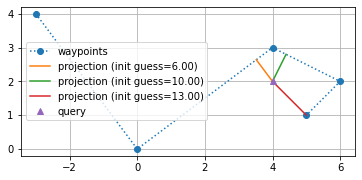

In [12]:
print("Be prepared! The following query point has 3 local minima!")
print("-"*30)
test_query = [4.0,2.0]
init_guess_list = (6.0, 10.0 , 13.0)
res_Frenet = test_projection(
    path_obj=mywaypoints,
    projection_method="project",
    test_query_pt= test_query, 
    expected_LHS=False,
    init_guess_list = init_guess_list,
    verbose=True
)
viz_projection(mywaypoints,test_query_pt=test_query,init_guess_list=init_guess_list, result_Frenet=res_Frenet)
plt.show()


Be prepared! The following query point has 2 local minima!
------------------------------
working on iteration 0: new iterate 4.200
working on iteration 1: new iterate 4.200
init guess: 2.00, final iterate: 4.20, (signed) projected distance: 0.60, took 0.18 msec
------------------------------
working on iteration 0: new iterate 5.600
working on iteration 1: new iterate 5.600
init guess: 6.00, final iterate: 5.60, (signed) projected distance: 0.80, took 1.1 msec
------------------------------


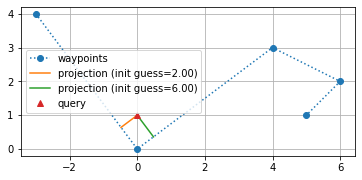

In [13]:
print("Be prepared! The following query point has 2 local minima!")
print("-"*30)
test_query = [0.0,1.0]
init_guess_list = (2.0, 6.0)
res_Frenet = test_projection(
    path_obj=mywaypoints,
    projection_method="project",
    test_query_pt= test_query, 
    expected_LHS=True,
    init_guess_list = init_guess_list,
    verbose=True
)
viz_projection(mywaypoints,test_query_pt=test_query,init_guess_list=init_guess_list, result_Frenet=res_Frenet)
plt.show()


In [14]:
# some perturbation to the query point
print(mywaypoints.project(np.array([-0.5,1.0]),arclength_init_guess=6.0)) # hang on to the 2nd segment
print(mywaypoints.project(np.array([-0.8,1.0]),arclength_init_guess=6.0)) # abrupt change!

(5.2, 1.1)
(3.7199999999999998, -0.040000000000000216)
